In [2]:
import json
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from math import ceil

# ────────────────────────────────────────────────────────────────────────────────
# CATEGORY MAP & FEATURE LIST
# ────────────────────────────────────────────────────────────────────────────────
categories_map = {
    'Input 1': [1,2],
    'Input 2': list(range(1,6)),
    'Input 3': list(range(1,6)),
    'Input 4': list(range(1,22)),
    'Input 5': list(range(1,6)),
    'Input 6': [1,2,3],
    'Input 7': [1,2,3,4],
    'Input 8': list(range(1,11)),
}
all_inputs     = [f'Input {i}' for i in range(1,19) if i != 12]
numeric_inputs = [f'Input {i}' for i in range(9,19) if i != 12]

# ────────────────────────────────────────────────────────────────────────────────
# MLP CLASS
# ────────────────────────────────────────────────────────────────────────────────
class MLPNet(nn.Module):
    def __init__(self, in_dim, hidden_dims, activations):
        super().__init__()
        layers = []
        dims = [in_dim] + hidden_dims
        for i, h in enumerate(hidden_dims):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            act = activations[i].lower()
            if act == 'relu':
                layers.append(nn.ReLU())
            elif act == 'tanh':
                layers.append(nn.Tanh())
            elif act == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif act == 'softplus':
                layers.append(nn.Softplus())
            else:
                raise ValueError(f"Unknown activation '{activations[i]}'")
        layers.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ────────────────────────────────────────────────────────────────────────────────
# SAMPLE-SWEEP FUNCTION WITH LOADED NORMS
# ────────────────────────────────────────────────────────────────────────────────
def sweep_plot_samples_mlp(
    model_path: str,
    norms_json: str,
    hidden_dims: list[int],
    activations: list[str],
    test_csv: str,
    sample_index: int = -1
):
    """
    Loads trained MLP & saved norms, evaluates on test data,
    and for each sample i:
      - Sweeps Input 10 over [0,3000]
      - Plots model output vs Input 10 curve
      - Overlays actual (Input10[i], Output[i]) point

    sample_index:
      >=0 : plot that sample only
      -1  : grid of all (3 per row)
      -2  : separate figure per sample
    """

    # 0) LOAD NORMS
    with open(norms_json, 'r') as f:
        norms = json.load(f)
    y_mean    = norms['y_mean']
    y_std     = norms['y_std']
    feat_mean = norms['feat_mean']
    feat_std  = norms['feat_std']

    # 1) LOAD & PREPROCESS TEST DATA
    df = pd.read_csv(test_csv)
    for c in ('F2','F3'):
        if c in df:
            df.drop(columns=[c], inplace=True)

    y_true = df['Output'].to_numpy(dtype=float)

    X = df[all_inputs].copy()
    # encode Inputs 1–8
    for col, cats in categories_map.items():
        if col not in X:
            continue
        if len(cats) == 2:
            X[col] = X[col].map({cats[0]: +1.0, cats[1]: -1.0})
        else:
            X[col] = pd.Categorical(X[col], categories=cats)
            dummies = pd.get_dummies(X[col], prefix=col)
            for c in cats:
                key = f"{col}_{c}"
                if key not in dummies:
                    dummies[key] = 0
            X = pd.concat([X.drop(columns=[col]), dummies], axis=1)

    # normalize numeric using loaded norms
    for col in numeric_inputs:
        X[col] = (X[col] - feat_mean[col]) / feat_std[col]

    Z_np = X.to_numpy(dtype=np.float32)

    # Input 10 norms
    mu10  = feat_mean['Input 10']
    sig10 = feat_std['Input 10']

    # 2) LOAD MODEL
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = MLPNet(Z_np.shape[1], hidden_dims, activations).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 3) PLOTTING FUNCTION
    def plot_sample(i, ax):
        Zi = Z_np[i:i+1]
        xi, yi = df['Input 10'].iloc[i], y_true[i]

        grid = np.linspace(0, 3000, 300)
        grid_norm = (grid - mu10) / sig10

        Zr = np.repeat(Zi, len(grid), axis=0).astype(np.float32)
        # replace normalized Input 10 column
        idx10 = all_inputs.index('Input 10')
        Zr[:, idx10] = grid_norm

        with torch.no_grad():
            Zt = torch.from_numpy(Zr).to(device)
            p_norm = model(Zt).cpu().numpy().flatten()

        p = p_norm * y_std + y_mean

        ax.plot(grid, p, linewidth=1)
        ax.scatter(xi, yi, color='red', s=20, zorder=5)
        ax.set_xlim(0, 3000)
        ax.set_xticks([0, 3000])
        ax.set_title(f"Sample {i}")
        ax.set_xlabel("Input 10")
        ax.set_ylabel("Output")

    N = len(y_true)
    # single sample
    if 0 <= sample_index < N:
        fig, ax = plt.subplots(figsize=(12,8))
        plot_sample(sample_index, ax)
        plt.tight_layout()
        plt.show()

    # separate figures
    elif sample_index == -2:
        for i in range(N):
            fig, ax = plt.subplots(figsize=(12,8))
            plot_sample(i, ax)
            plt.tight_layout()
            plt.show()

    # grid of samples
    else:
        cols = 3
        rows = ceil(N / cols)
        fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*6))
        axs = axs.flatten()
        for i in range(N):
            plot_sample(i, axs[i])
        for j in range(N, len(axs)):
            fig.delaxes(axs[j])
        plt.tight_layout()
        plt.show()




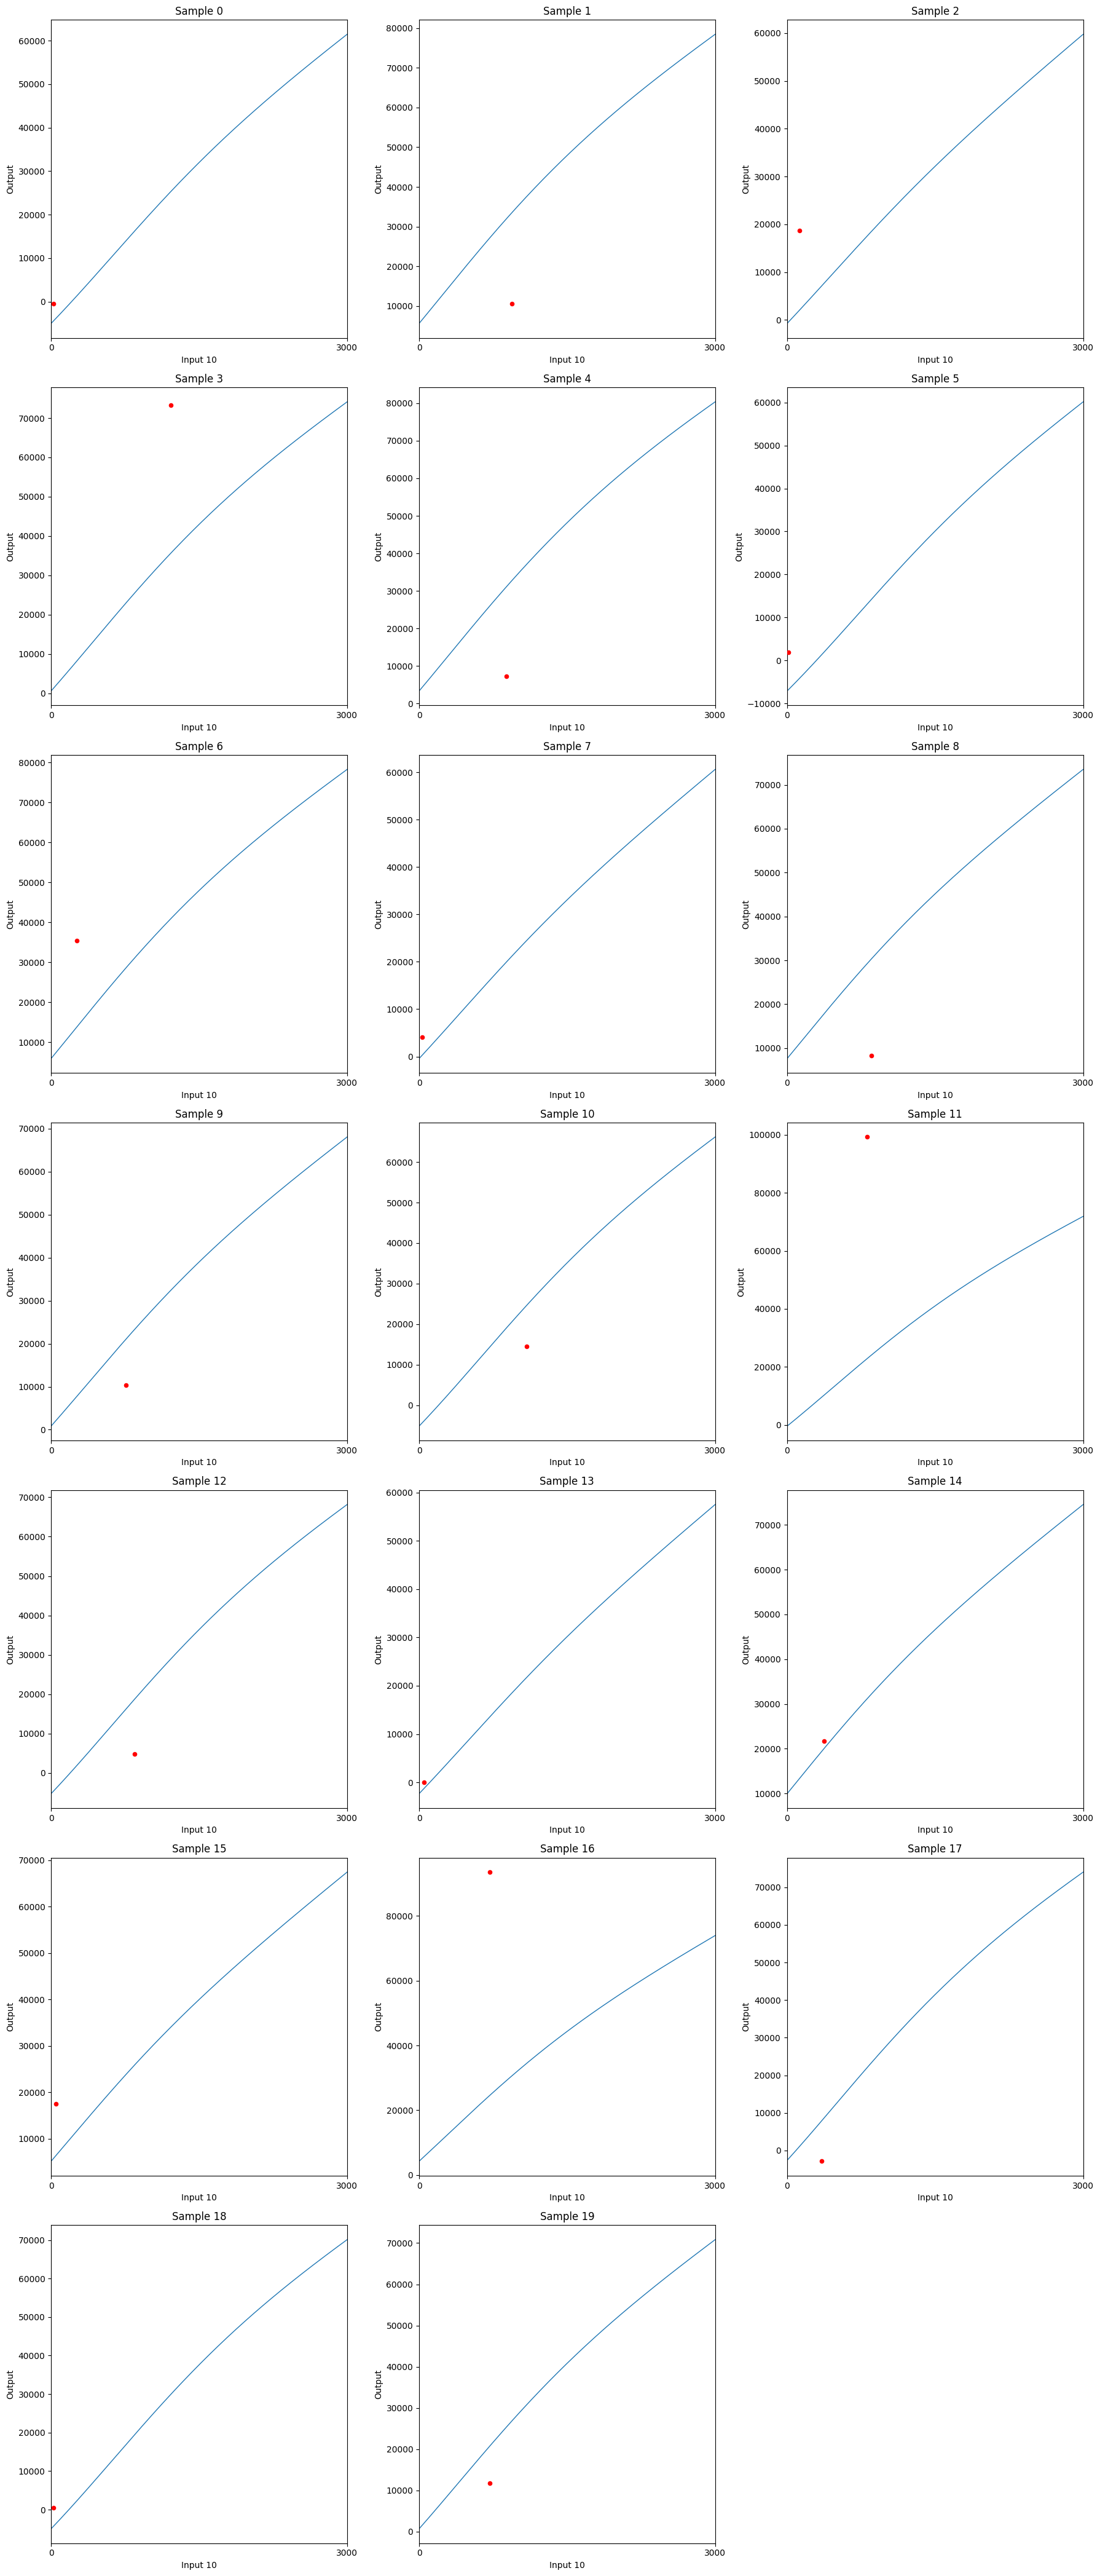

In [3]:
# ────────────────────────────────────────────────────────────────────────────────
# USAGE
# ────────────────────────────────────────────────────────────────────────────────
if __name__ == '__main__':
    sweep_plot_samples_mlp(
        model_path   = "/home/kamiar/chevron/Acid-neural-net/First Data-V3/58c0fccc/58c0fccc_fold4.pth",
        norms_json   = "/home/kamiar/chevron/Acid-neural-net/First Data-V3/58c0fccc/58c0fccc_norms.json",
        hidden_dims  = [4,4],
        activations  = ['softplus','softplus'],
        test_csv     = "/home/kamiar/chevron/Acid-neural-net/First Data-V3/data/test.csv",
        sample_index = -1
    )
